# Test

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from learn import *
sys.path.insert(0, 'code')
from v17 import *
from v17 import _internal_validate_predict_best_param
sys.path.insert(0, 'Pytorch-UNet/utils')
from crf import dense_crf

In [3]:
sz = 256
num_slice = 9

num_gpus = 2
gpu_start = 8
num_workers = 8
device_ids = range(gpu_start, gpu_start + num_gpus)
# device_ids = [4,5,8,9]
torch.cuda.set_device(gpu_start)
bs = 8

model_name = 'deeplab'
datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
datapath = datapaths[3]

## Scripting

In [1]:
%%time
%run test 3 --num_gpus=2 --gpu_start=8 --bs=8 --pred


Data finished loading: data/train/AOI_5_Khartoum_Train
CPU times: user 35min 37s, sys: 3min 33s, total: 39min 10s
Wall time: 2min 1s


## Polygon best threshold

In [2]:
def evalfscore_thresh(thresh):
    return evalfscore(datapath, preds, thresh=thresh)

In [3]:
%%time
threshs = np.linspace(0, 1, 21)
polygon_pr = []
for thresh in threshs:
#     with ThreadPoolExecutor(max_workers=8) as e:
    s = evalfscore_thresh(thresh)
    print(s)
    polygon_pr.append(s)
# plt.plot(polygon_pr)

(0, 0, 0)
(0.048611, 0.086242, 0.033844)
(0.134281, 0.253542, 0.091324)
(0.182172, 0.331678, 0.125571)
(0.217713, 0.383339, 0.152028)
(0.244674, 0.414767, 0.173516)
(0.274612, 0.446089, 0.198362)
(0.30386, 0.473954, 0.22361)
(0.331237, 0.473763, 0.254633)
(0.338876, 0.464144, 0.266855)
(0.333083, 0.439384, 0.268198)
(0.32125, 0.411099, 0.263631)
(0.294094, 0.370635, 0.243755)
(0.255042, 0.317463, 0.213135)
(0.19944, 0.246491, 0.167472)
(0.141749, 0.177963, 0.117781)
(0.081486, 0.108054, 0.065404)
(0.035923, 0.054215, 0.02686)
(0.007607, 0.017831, 0.004835)
(0, 0, 0)
CPU times: user 54min 31s, sys: 3min 36s, total: 58min 7s
Wall time: 32min 32s


In [8]:
c = children(learn.model.module)

In [5]:
fscore = [o[0] for o in polygon_pr]

0.5 0.338876


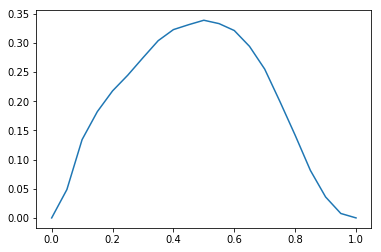

In [6]:
plt.plot(threshs, fscore)
plt.xlabel = 'threshold'
plt.ylabel = 'fscore'
print(np.argmax(fscore) / 20, fscore[np.argmax(fscore)])

## Preprocessing

In [4]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[0]}

In [5]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[3]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_test {datapaths[2]}

In [7]:
model_name = 'deeplab'
data = None
is_eval, is_pred = True, False

In [8]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-5')


Data finished loading: data/train/AOI_5_Khartoum_Train


## evalfscore

In [9]:
%%time
preds = learn.predict().squeeze()

CPU times: user 38min 33s, sys: 3min 25s, total: 41min 59s
Wall time: 1min 44s


In [10]:
evalfscore(datapath, preds)

(0.508879, 0.257857)

In [ ]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]
print(preds.shape)

In [ ]:
scores = None

In [ ]:
scores, idx = plot_worse_preds(x, y, preds, learn, jaccard_coef, shift=600,
                          scores=scores, is_best=0, thresh=0.5)

## testproc

In [16]:
data = None
is_eval, is_pred = False, True

In [17]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-5')

Data finished loading: data/train/AOI_5_Khartoum_Train


In [18]:
%%time
preds = learn.predict().squeeze()

CPU times: user 1h 37min 59s, sys: 13min 50s, total: 1h 51min 50s
Wall time: 5min 18s


In [19]:
testproc(datapath, preds)

## Plot images after putting back

In [ ]:
fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix='AOI_2_Vegas')
df_train = pd.read_csv(fn_train)

In [ ]:
df_train[df_train.ImageId == 'AOI_2_Vegas_img485']

In [ ]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds])
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)])
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y])
x_big[0].shape

In [ ]:
idx = 89
data_im = zip(preds_big[idx:idx + 9], x_big[idx:idx + 9], y_big[idx:idx + 9])
plot_ims(data_im, figsize=4)

In [ ]:
idx = 96
crfed = dense_crf((x_big[idx] * 255).astype('uint8'), (preds_big[idx]), 1, 7, 1)
plt.imshow(preds_big[idx] > 0.3)
print(jaccard_coef_cuda((V(preds_big[idx]) > 0.3).float(), V(y_big[idx])).data[0])

In [ ]:
best_sxy1, best_sxy2, best_srgb = 0, 0, 0
best_jac = 0
# rows, cols = 3, 3
# sx1 = np.arange(1, , ).astype('uint8')
# eps = np.arange(1, 80, 80 / cols).astype('uint8')
# res = np.empty([rows, cols] + list(srcs.shape))
for sxy1 in np.arange(1, 10, 3):
    for sxy2 in np.arange(1, 10, 3):
        for srgb in np.arange(1, 10, 3):
            crfed = dense_crf((x_big[idx] * 255).astype('uint8'), (preds_big[idx]),
                             sxy1=sxy1, sxy2=sxy2, srgb=srgb)
            jac = jaccard_coef_cuda(V(crfed), V(y_big[idx])).data[0]
            if jac > best_jac:
                best_jac = jac
                best_sxy1, best_sxy2, best_srgb = sxy1, sxy2, srgb
                print(sxy1, sxy2, srgb, jac)
print(best_sxy1, best_sxy2, best_srgb, best_jac)

In [ ]:
crfed = dense_crf((x_big[idx] * 255).astype('uint8'), (preds_big[idx]),
                             sxy1=1, sxy2=1, srgb=1)